# Predicting Titanic survivors with random forest classification

In this study I will use random forest classification to predict if a person survived or not.

Source of data: https://www.kaggle.com/c/titanic/data

First let's import the libraries that will be used for the calculations. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

The data is split to train and test subsets, where the 'Survived' column is missing from the test set.
Let's create a Pandas data frame from the train set.

In [2]:
train = pd.read_csv('train.csv')

# Data preprocessing

We must make sure that the data well processed in terms of missing data, relevancy before fitting it to a machine learning algorithm. Let's see take at the data.

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The **Survived** column contains result if the given person survived(1) or deceased(0).
The values of the **Pclass** column represents the passenger socio-economic status. 1 for upper, 2 for middle and 3 for low class.
The **SibSp** contains the number of siblings aboard the Titanic, similarly the **Parch** column contains the number of spouses on board(wife or husband).

After checking some entries of the dataset we can see that there are some missing values in th **Cabin** column. Let's see if there is more columns with missing data. In order to do so, it is conveninent to visualize the features based on where are missing entries. We can use heatmap to check this.

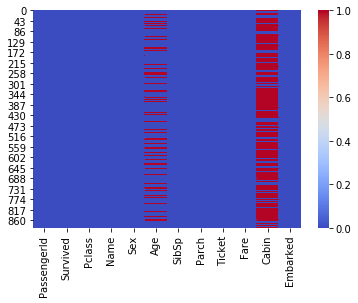

In [4]:
sns.heatmap(train.isnull(), cmap='coolwarm')

In the figure above the missing data points are indicated with red (1) and every non-null data with blue (0). We can conclude that the **Age** and the **Cabin** columns have missing data points. We can get rid of the **Cabin** column competely due to its missing data points, and the presumption that there is no statistical significance attributed to the cabin codes in the model. Considering the we drop the **Cabin** column along with **Name** and **Ticket** columns.

In [5]:
train = train.drop(['Cabin', 'Name', 'Ticket'], axis=1)

On the other hand, actions must be done with missing data in the **Age** column.

Before that, let's create a boxplot of the age data for each socio-economic class.

Text(0.5, 0, 'Socio-ecomomic class')

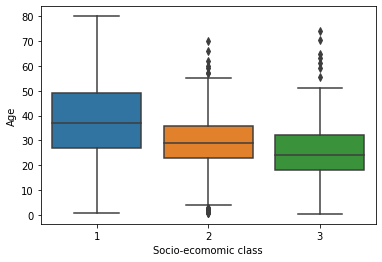

In [6]:
sns.boxplot(x='Pclass', y='Age', data=train)
plt.xlabel('Socio-ecomomic class')

As we can see in the plot above, the first class passengers tend to be older than the lower class passengers.

We could easily impute missing values by taking the mean value of the **Age** column, but perhaps we can have a more accurate approximation if we replace these values with the mean age values of the corresponding socio-economic class.

Let's define a function for this approach, which we can apply to the **Age** column.

In [7]:
def impute_age(cols):
    """
    cols: DataFrame object
    Returns mean age for each Pclass if the value is NaN, else returns Age.
    """
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        
        if Pclass == 1:
            return np.mean(train[train['Pclass'] == 1]['Age'])
        elif Pclass == 2:
            return np.mean(train[train['Pclass'] == 2]['Age'])
        else:
            return np.mean(train[train['Pclass'] == 3]['Age'])
    else:
        return Age
    
train['Age'] = train[['Age', 'Pclass']].apply(impute_age, axis=1)

Since we have categorical data in the **Sex** and **Emarked** column, we must encode them.

In [8]:
sex = pd.get_dummies(train['Sex'], drop_first=True) # Creating a new DataFrame with dummy variables for the sex column
emb = pd.get_dummies(train['Embarked'], drop_first=True) # Creating a new DataFrame with dummy variables for the embarked column
train = pd.concat([train, sex, emb], axis=1) # Concatenating the datasets
train = train.drop(['Sex', 'Embarked'], axis=1) # Dropping remaining sex and embarked columns

Now the data is cleared and ready to process.

In [9]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1


# Classification with random forest classifier

Let's split the dataset to training set and test set. We use 30 % of the data for testing the estimation.

In [10]:
from sklearn.model_selection import train_test_split
X = train.drop('Survived', axis=1)
y = train['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11)

Let's create a classifier object with an initial number of estimators: n = 200.

In [11]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=200, random_state=11)

Fitting the training data to the learning model.

In [12]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=11, verbose=0,
                       warm_start=False)

Let's create a confusion matrix and a classification report based on prediction of the model.

In [13]:
from sklearn.metrics import confusion_matrix, classification_report
pred_rfc = rfc.predict(X_test)
print(confusion_matrix(y_test, pred_rfc))
print(classification_report(y_test, pred_rfc))

[[158  18]
 [ 29  63]]
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       176
           1       0.78      0.68      0.73        92

    accuracy                           0.82       268
   macro avg       0.81      0.79      0.80       268
weighted avg       0.82      0.82      0.82       268



If we run the calculation multiple times we can see that the accuracy score is 0.82. Let's see if we can reach a higher accuracy by fitting the model for max_depth=[0, 10] range.

In [14]:
errorRateDepth = []
depthList= list(range(1, 10))
for i in depthList:
    rfcOpt = RandomForestClassifier(n_estimators=200, max_depth=i, random_state=11)
    rfcOpt.fit(X_train, y_train)
    predOpt = rfcOpt.predict(X_test)
    errorRateDepth.append(np.mean(y_test != predOpt))

Let's visualize the error_rate list by the max depth.

Text(0, 0.5, 'Error rate')

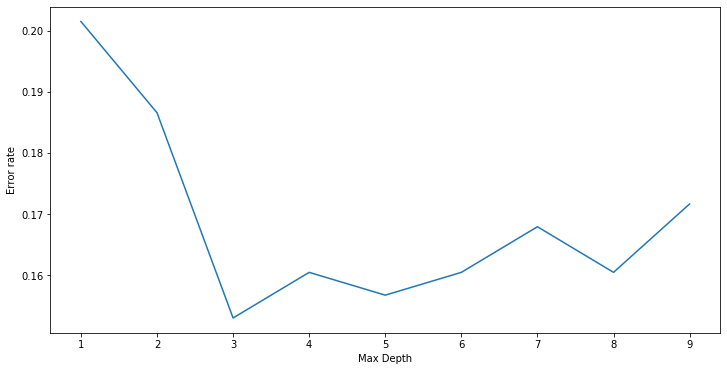

In [15]:
plt.figure(figsize=(12,6))
plt.plot(depthList, errorRateDepth)
plt.xlabel('Max Depth')
plt.ylabel('Error rate')

We can see in the plot above, that max_depth=3 value had the lowest error rate. Let's calculate and evaluate the model with this value.

In [16]:
rfc_opt = RandomForestClassifier(n_estimators=200, max_depth=3)
rfc_opt.fit(X_train, y_train)
pred_rfc_opt = rfc_opt.predict(X_test)
print(confusion_matrix(y_test, pred_rfc_opt))
print(classification_report(y_test, pred_rfc_opt))

[[165  11]
 [ 29  63]]
              precision    recall  f1-score   support

           0       0.85      0.94      0.89       176
           1       0.85      0.68      0.76        92

    accuracy                           0.85       268
   macro avg       0.85      0.81      0.83       268
weighted avg       0.85      0.85      0.85       268



This time we could reach a slightly better accuracy of 0.85.